# Fine-Tuning BERT for Sentiment Analysis

## Preprocessing data

### Import torch and transformers, connecting to Google Drive, check GPU

In [ ]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
#from nltk.corpus import stopwords
import nltk
import re
from tabulate import tabulate
from tqdm import trange
import glob

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
#verificare la disponibilità di cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(torch.cuda.get_device_name(0))
print(device)

Tesla T4
cuda:0


### Dataframe creation from dataset files

In [ ]:

df_neg = pd.DataFrame({'label': pd.Series(dtype='int'),'text': pd.Series(dtype='str')
                   })

for file in glob.glob("/content/drive/MyDrive/review_polarity/txt_sentoken/neg/*.txt"):
  
  with open(file) as f:
    contents = f.read()
    # print(contents)
  
  new_row = {'label':0, 'text':contents}
  df_neg = df_neg.append(new_row, ignore_index=True)

print("------------ df_neg----------------")
print(df_neg)

df_pos = pd.DataFrame({'label': pd.Series(dtype='int'),'text': pd.Series(dtype='str')
                   })

for file in glob.glob("/content/drive/MyDrive/review_polarity/txt_sentoken/pos/*.txt"):
  
  with open(file) as f:
    contents = f.read()
    # print(contents)
  
  new_row = {'label':1, 'text':contents}
  df_pos = df_pos.append(new_row, ignore_index=True)

print("------------ df_pos----------------")
print(df_pos)

df = pd.concat([df_neg, df_pos], ignore_index=True)

print("------------ df----------------")
print(df)
df.head()
# df.tail(20)



------------ df_neg----------------
     label                                               text
0        0  plot : two teen couples go to a church party ,...
1        0  the happy bastard's quick movie review \ndamn ...
2        0  it is movies like these that make a jaded movi...
3        0   " quest for camelot " is warner bros . ' firs...
4        0  synopsis : a mentally unstable man undergoing ...
..     ...                                                ...
995      0  if anything , " stigmata " should be taken as ...
996      0  john boorman's " zardoz " is a goofy cinematic...
997      0  the kids in the hall are an acquired taste . \...
998      0  there was a time when john carpenter was a gre...
999      0  two party guys bob their heads to haddaway's d...

[1000 rows x 2 columns]
------------ df_pos----------------
     label                                               text
0        1  films adapted from comic books have had plenty...
1        1  every now and then a mo

,label,text
0,0,"plot : two teen couples go to a church party ,..."
1,0,the happy bastard's quick movie review \ndamn ...
2,0,it is movies like these that make a jaded movi...
3,0,""" quest for camelot "" is warner bros . ' firs..."
4,0,synopsis : a mentally unstable man undergoing ...


### Delete stopwords

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('english')

def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:,/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

# remove stopwords if needed
df['text'] = df['text'].apply(lambda x: clean_text(x))
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,text
0,0,plot two teen couples go church party drink dr...
1,0,happy bastard quick movie review damn k bug go...
2,0,movies like make jaded movie viewer thankful i...
3,0,quest camelot warner bros first feature length...
4,0,synopsis mentally unstable man undergoing psyc...
...,...,...
1995,1,wow movie everything movie funny dramatic inte...
1996,1,richard gere commanding actor always great fil...
1997,1,glory starring matthew broderick denzel washin...
1998,1,steven spielberg second epic film world war ii...


### Shuffle data

In [ ]:
## Shuffle Data
def shuffle(df, n=3, axis=0):     
    df = df.copy()
    random_states = [2,42,4]
    for i in range(n):
        df = df.sample(frac=1,random_state=random_states[i]) # mischio il dataframe 
    return df

new_df = shuffle(df)
new_df

,label,text
1608,1,magnolia left relling theatre staggering relen...
917,0,michael robbins hardball quite cinematic achie...
855,0,vegas vacation fourth film starring chevy chas...
428,0,dialogue film taken almost completely context ...
1740,1,couple months ago first downloaded face traile...
...,...,...
1583,1,saw night hunter long time since gasped watchi...
1091,1,accepting oscar producer year best picture win...
516,0,warning signs terrible movie making debut doll...
1817,1,showgirls second major outing production team ...


### Reset index

In [ ]:
new_df = new_df.reset_index(drop=True)  # ordino per prendere 80%
new_df.head()

,label,text
0,1,magnolia left relling theatre staggering relen...
1,0,michael robbins hardball quite cinematic achie...
2,0,vegas vacation fourth film starring chevy chas...
3,0,dialogue film taken almost completely context ...
4,1,couple months ago first downloaded face traile...


### Train Test Split

In [ ]:
split_idx = int(len(df)*0.8)

train_df = new_df.loc[:split_idx,:]
test_df = new_df.loc[split_idx:,:]
print('train lenght:',len(train_df))
print(train_df.groupby(['label'])['text'].count())
print('test lenght:',len(test_df))
print(test_df.groupby(['label'])['text'].count())

# controllo che label 0 e 1 bilanciati altrimenti rieseguo shuffle

train lenght: 1601
label
0    798
1    803
Name: text, dtype: int64
test lenght: 400
label
0    203
1    197
Name: text, dtype: int64


In [ ]:
sentences = train_df.text
labels = list(train_df.label)

## Fine-Tuning

### esempio di tokenizzazione

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
index=0
print(' Original: ', list(sentences)[index])


#print('Tokenized: ', tokenizer.tokenize(comms[index])) # Print the sentence split into tokens.

#print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(comms[index]))) # Print the sentence mapped to token ids.

table = np.array([tokenizer.tokenize(list(sentences)[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(list(sentences)[index]))]).T
print(tabulate(table,headers = ['Tokens', 'Token IDs'],tablefmt = 'fancy_grid'))



 Original:  magnolia left relling theatre staggering relentless assault adventurous director reveling craft nearly three half hours magnolia strike brute film demands attention challenges grasp significance seemingly unrelated storylines hidden intentions delirious depressing heady pretentious surreal filmmaking also movie polarize viewers director paul thomas anderson takes talented cast wraps net interrelated stories sets spinning symphony despair whose song let oddly exhilerating biblically influenced pseudo climax character make modern day gomorrah soulless way live lives frank mackey tom cruise slithery snake charmer men whose search destroy seminars teach mentally rape woman get pants earl partridge jason robards dying media tycoon yearning make amends lfe callousness finding estranged son game show host jimmy gator phillip baker hall self absorbed tv icon hiding secrets public police officer jim kurring john c reilly cloaks codification organized religion legal system perhaps ma

### Add special tokens

In [ ]:
max_len = 0
l=[]
# For every sentence...
for sent in list(sentences):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    l.append(len(input_ids))
    max_len = max(max_len, len(input_ids))

if max_len>512:
  max_len=512
avg_len=int(sum(l)/len(l))

print('Max sentence length: ', max_len)
print('Avg sentence length: ', avg_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (1006 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  512
Avg sentence length:  408


In [ ]:
MAX_LEN = 512
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Esempio di Encoding

In [ ]:
# Print sentence 0, now as a list of IDs.
i=random.randint(0,len(sentences)-1)
print('Original: ', list(sentences)[i])
print('Input IDs:', input_ids[i])

Original:  bob happy bastard quickie review matrix worse k fully digital future nothing real computer programmer neo keanu reeves slowly learns enters dangerous world matrix movie directed wachowski brothers guys behind hip thriller bound groan presence reeves lead role hold actually story depth seems group hackers stop system matrix led bald brilliant laurence fishburne assisted carrie ann moss looks quite cool leather must say neo reeves pretty much key player fight although really look first could amateur one fisburne thinks credit wachowskis putting together great story allows suspense build something special effects laden films seem days plenty effects go around course least backbone build well reeves surprisingly good role neo particularly fight scene fishburne comes across goofy yet great wish villains quite generic leftover g men looking sweet sci fi actioner plenty stop motion swooping camera angles course motherlode helicopter explosion wachowskis headed horror films next pro

In [ ]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(sentences) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(input_ids[index]))
  token_ids = [i.numpy() for i in input_ids[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(list(sentences)[index])
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

one point brian de palma crime epic scarface radiant michelle pfeiffer turns ranting al pacino pops question audience doubt wanting ask stop saying fuck time fucking good question may honour instills filmmakers pride far tell oliver stone script contains said expletitive times film cinema history yet would shame bad language de palma scarface remembered damn fine gangstar flick overall structure similar howard hawks original time scene switched miami florida anti hero chosen vice cocaine traffiking pacino sporting thick cuban accent gives one best performances career golden globe nominated tony montana cuban refugee criminal past flees castro comes america live american dream live lashings violence abuse murder funny white powder earliest jobs drug runner various middlemen tony montana makes clear everyone meets man fucked sorry soon king cocaine heap hot head increasingly control drug addiction prove undoing never stash warns one character early film sure night follows day emperor mia

### Train Validation Split

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,280 training samples
  321 validation samples


Train parameters
The optimal hyperparameter values are task-specific, but we found the following range of possible values to work well across all tasks:

- Batch size: 16, 32

- Learning rate (Adam): 5e-5, 3e-5, 2e-5

- Number of epochs: 2, 3, 4

### Create train and validation data loader

In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### Create BERT model

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# if device == "cuda:0":
# # Tell pytorch to run this model on the GPU.
#     model = model.cuda()
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Fine tuning the model

In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []
best_eval_accuracy = -np.Inf

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs"
        model.zero_grad()
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)  
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value;                           
        loss = output.loss
        logits = output.logits
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    #best_eval_accuracy = np.Inf
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    #save the best model
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'bert_model_b16_ml512_binary')
        best_eval_accuracy = avg_val_accuracy

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.67
  Training epoch took: 0:02:00

Running Validation...
  Accuracy: 0.58
  Validation Loss: 0.68
  Validation took: 0:00:11

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.44
  Training epoch took: 0:01:59

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.49
  Validation took: 0:00:11

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.27
  Training epoch took: 0:01:59

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.42
  Validation took: 0:00:11

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.14
  Training epoch took: 0:01:59

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.43
  Validation took: 0:00:11

Training complete!
Total training took 0:08:44 (h:mm:ss)


### Training statistics

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

# 4 TROPPE EPOCHE QUI PERCHE' POCHI DATI

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.67,0.68,0.58,0:02:00,0:00:11
2,0.44,0.49,0.78,0:01:59,0:00:11
3,0.27,0.42,0.84,0:01:59,0:00:11
4,0.14,0.43,0.83,0:01:59,0:00:11


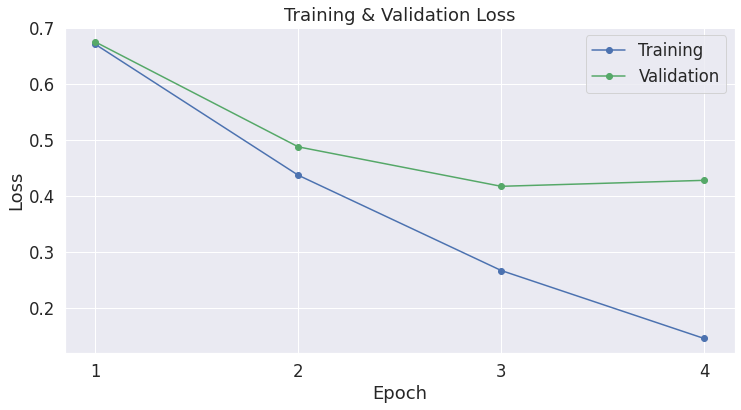

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# vediamo andamento
# quando validation aumenta con training c'è overfitting

An **underfit** model can be identified from the learning curve of the training loss only.

It may show a flat line or noisy values of relatively high loss, indicating that the model was unable to learn the training dataset at all.

An example of this is provided below and is common when the model does not have a suitable capacity for the complexity of the dataset.

A plot of learning curves shows **underfitting** if:

- The training loss remains flat regardless of training.
- The training loss continues to decrease until the end of training.

A plot of learning curves shows **overfitting** if:

- The plot of training loss continues to decrease with experience.
- The plot of validation loss decreases to a point and begins increasing again.

A plot of learning curves shows a **good** fit if:

- The plot of training loss decreases to a point of stability.
- The plot of validation loss decreases to a point of stability and has a small gap with the training loss.

## Test

### Loading the best model

In [116]:
model = torch.load('bert_model_b16_ml512_binary')
# salvataggio servito se allenamento una volta e test un'alta volta

### Test performance

In [117]:
# Create sentence and label lists
sentences = test_df.text.values # test_dataset.text
labels = test_df.label.values # test_dataset.label

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
# batch_size = 32  
batch_size = 16 

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [118]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval() # qua valutazione per test, non per validation

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 400 test sentences...
    DONE.


In [119]:
from functools import reduce
scores = reduce(lambda x,y: x+y,[list(map(np.argmax,p)) for p in predictions])
labels = reduce(lambda x,y: list(x) + list(y), true_labels)

from sklearn.metrics import accuracy_score
accuracy_score(scores, labels)

0.875

### Confusion Matrix

In [120]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

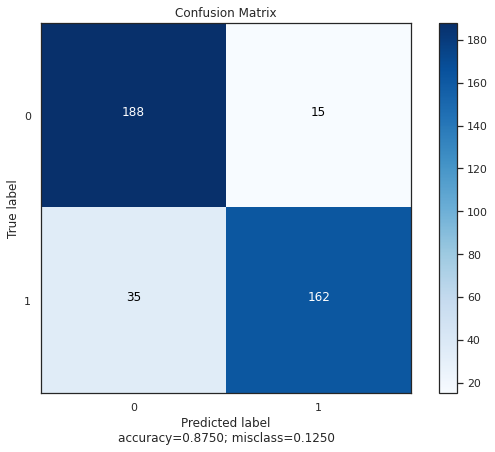

In [121]:
from sklearn.metrics import confusion_matrix

sns.set(font_scale=1)
sns.set(style='white')


cm = confusion_matrix(labels,scores)
plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix")